# Repetitive Model Evaluation Using Multinest

This is an example of the use of Multinest in order to evaluate a model based on data.

The notebook creates points based on the "model_generator()" function (5 + cos(12\*k + pi/25). These points will simulate the acquired from an experiment.

## Parameters
This section is dedicated to import the essential libraries, set the initial parameters that will be used throughout the notebook.

In [1]:
#Importing all necessary libraries
import numpy
from numpy import sqrt, exp, log, pi, sin, cos
import scipy
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import json
import pymultinest
import os
import sys
from wand.image import Image as WImage
from IPython.display import IFrame
#Necessary to present plots in jupyter
%matplotlib inline

#Number of repetitions of multinest
n_reps = 100
#Number of points to be simulated
n_points = 10000
#Folder name where files will be saved
foldername = 'output'

#Parameters used for the model_generator function
vertical_shift = 5.
amplitude = 1.
frequency = 12.
phase = pi/25.

#Bin parameters for point generation
x_min = 0
x_max = 1
n_bins = 50

#Creates an array of x-values for the bins
x_data = numpy.linspace(x_min, x_max, n_bins)

#Shift function parameters
y_shift_mean = 0
y_shift_sigma = .005*n_points

#Tilt function parameters
y_tilt_mean = 0
y_tilt_sigma = .01*n_points

#Scattering function parameters
systematic_error_percentage = .05

#Parameter list for plotting reasons:
parameters = ["A", "B", "C", "D", "E"]
n_params = len(parameters)

## Definitions
This section is dedicated to define all the functions that will be used thorugh the notebook.

In [2]:
#Correct model from which the points will be generated
def model_generator():
    return vertical_shift + amplitude*cos(frequency * x_data + phase)

#Returns the correct value for each parameter A, B, C, D and E
def correct_parameters():
    current_n_points = sum(model_generator())
    correct_params = []
    correct_params.append(vertical_shift * n_points / current_n_points)
    correct_params.append(0)
    correct_params.append(amplitude * n_points / current_n_points)
    correct_params.append(frequency)
    correct_params.append(phase)
    return correct_params

#Makes sure that the number of points under the histogram is the number of points
def scale_y_data(y):
    current_n_points = sum(model_generator())
    return y * n_points / current_n_points
    
#Shifts all points globally by a random normal distributed amount
def shift_y_data(y):
    y_shift = numpy.random.normal(y_shift_mean, y_shift_sigma)
    res = y + y_shift
    #Makes sure there will be no negative values for any y data
    while min(res) < 0:
        y_shift = numpy.random.normal(y_shift_mean, y_shift_sigma)
        res = y + y_shift*n_points
    return res

#Tilts each point depending on their distance from the center bin (center bin will not shift)
def tilt_y_data(y):
    y_tilt = numpy.random.normal(y_tilt_mean, y_tilt_sigma)
    res = y;
    for i in range(len(y)):
        res[i] = y[i] + y_tilt * (x_data[i] - ((x_max-x_min) / 2. + x_min))
    #Makes sure there will be no negative values for any y data
    while min(res) < 0:
        y_tilt = numpy.random.normal(y_tilt_mean, y_tilt_sigma)
        res = y;
        for i in range(len(y)):
            res[i] = y[i] + y_tilt * (x_data[i] - ((x_max-x_min) / 2. + x_min))
    return res

#Calculates the error for each individual x-y point
def calculate_y_error(y):
    sys_error = systematic_error_percentage * y
    stat_error = sqrt(y)
    return sqrt(sys_error**2 + stat_error**2)

#Scatters the x-y values gaussianly according to the error found on the previous step.
def scatter_y_data(y, y_error):
    res = y + numpy.random.normal(0,y_error)
    while min(res) < 0:
        res = y + numpy.random.normal(0,y_error)
    return res

#----------vvv PyMultiNest Definitions vvv----------
#Model to be evaluated and run on MultiNest.
def model(cube):
    #Each cube defines the prior for each parameters.
    A = cube[0]
    B = cube[1]
    C = cube[2]
    D = cube[3]
    E = cube[4]
    #Returns the model function.
    return lambda z: A + B*z + C*cos(D*z + E)

#Defines prior
def prior(cube, ndim, nparams):
    #These ratios work well enough.
    cube[0] = cube[0]*5000.*(n_points/(50000.)) - 2500.*(n_points/(50000.))
    cube[1] = cube[1]*.6*n_points-.3*n_points
    cube[2] = cube[2]*2000*(n_points/(50000.)) - 1000*(n_points/(50000.))
    cube[3] = cube[3]*20
    cube[4] = cube[4]*.575 - .25


#Defines log-likelihood function
def loglike(cube, ndim, nparams):
    modelNow = model(cube)(x_data)
    loglikelihood = (-0.5*((modelNow - y_data) / y_error)**2).sum()
    return loglikelihood
#----------^^^ PyMultiNest Definitions ^^^----------


## Creating points

### Creating one set of points

<Container object of 3 artists>

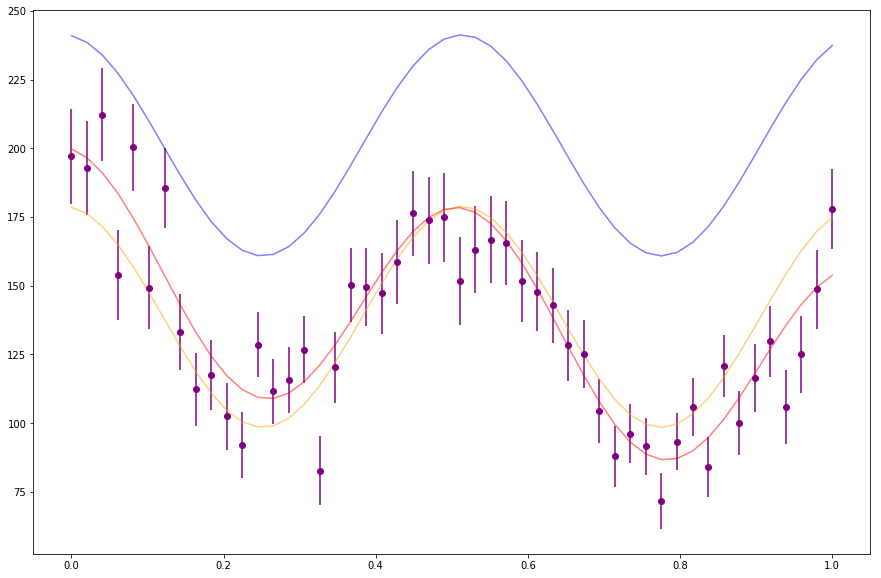

In [3]:
#Defines the figure size
fig_size = [15,10]
#Implements figure size on the next matplotlib session
plt.rcParams["figure.figsize"] = fig_size

#initialized a single subplot named "plots"
fig, plots = plt.subplots()

#Creates the y_data of the bins from the model generator function
y_data = model_generator()
#Scales the y_data such that the total number of points in the histogram is exactly n_points
y_data = scale_y_data(y_data)
#Plots current histogram line in blue.
plots.plot(x_data, y_data, '-', color = 'blue', alpha = .5)

#Shifts the y_data up or down by a random amount. 
y_data = shift_y_data(y_data)
#Plots current histogram line in orange.
plots.plot(x_data, y_data, '-', color = 'orange', alpha = .5)

#Tilts the y_data up or down by a random amount around the middle bin. 
y_data = tilt_y_data(y_data)
#Plots current histogram line in red.
plots.plot(x_data, y_data, '-', color = 'red', alpha = .5)

#Calculates the error for each y_data point
y_error = calculate_y_error(y_data)
#Scatters the y_data randomly around their current position with standard deviation y_error
y_data = scatter_y_data(y_data, y_error)
#Plots the scattered data points and respective errors.
plots.errorbar(x_data, y_data, yerr = y_error, fmt = 'o', color = 'purple')

### Running multinest for the one data set

  analysing data from output_mn/mn_output_.txt


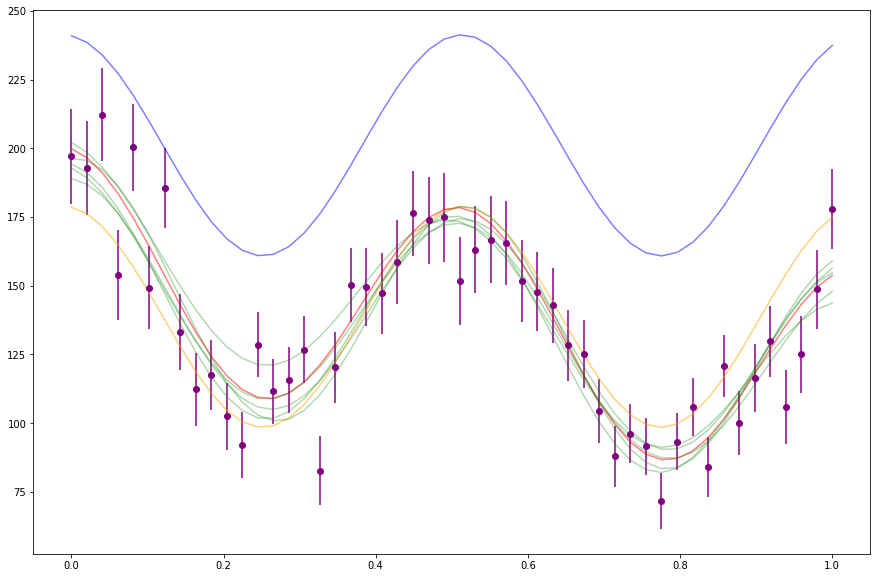

In [5]:
plt.close('all')
calculated_params = []
calculated_params_err = []

if not os.path.exists(foldername + '_mn'):
    os.mkdir(foldername + '_mn')

pymultinest.run(loglike, prior, n_params, outputfiles_basename = foldername + '_mn/mn_output_', resume = False, verbose = False, n_live_points = 200)
json.dump(parameters, open(foldername + '_mn/jsondump.json', 'w'))
    
analysis = pymultinest.Analyzer(outputfiles_basename=foldername + "_mn/mn_output_", n_params = n_params)
    
for (A, B, C, D, E) in analysis.get_equal_weighted_posterior()[::200,:-1]:
    plots.plot(x_data, model([A, B, C, D, E])(x_data), '-', color='green', alpha=.3, label='data')

fig

### Statistics

In [6]:
for i in range(n_params):
    calculated_params.append(analysis.get_mode_stats()['modes'][0]['maximum'][i])
    calculated_params_err.append(analysis.get_mode_stats()['modes'][0]['sigma'][i])
log_evidence = analysis.get_mode_stats()['global evidence']
log_evidence_err = analysis.get_mode_stats()['global evidence error']

for i in range(n_params):
    print "Parameter " + parameters[i] + ":"
    print "mean: " + str(calculated_params[i])
    print "sigma " + str(calculated_params_err[i])
    print "\n"
print "Log-evidence:"
print "mean: " + str(log_evidence)
print "sigma: " + str(log_evidence_err)

    

Parameter A:
mean: 154.078561224
sigma 4.09191222214


Parameter B:
mean: -36.456037359
sigma 6.87976409231


Parameter C:
mean: 39.2045008476
sigma 2.6770683333


Parameter D:
mean: 11.9843858478
sigma 0.213829613011


Parameter E:
mean: 0.097184935256
sigma 0.119535405343


Log-evidence:
mean: -48.2881443148
sigma: 0.287734524488


### Creating n_reps sets of points

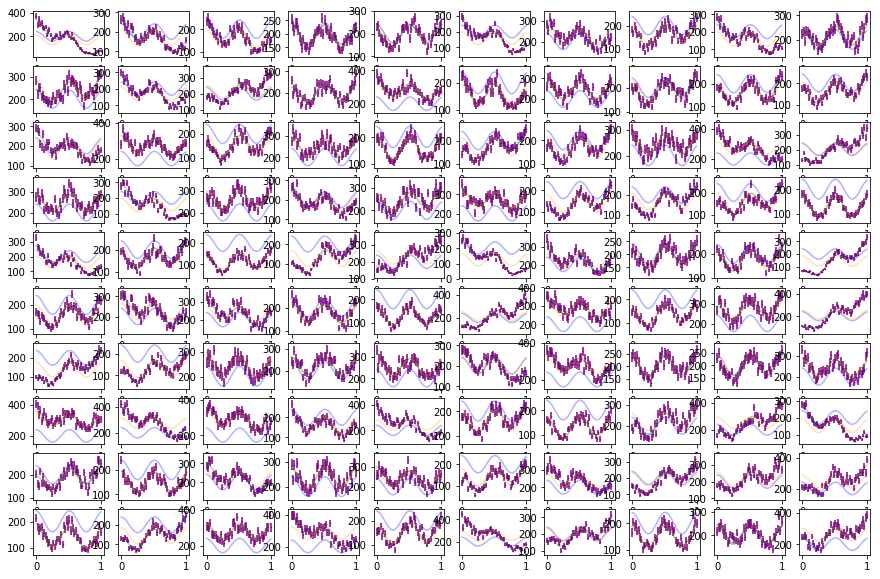

In [7]:
#Closes last session of matplotlib
plt.close('all')

#Defines the figure size
fig_size = [15,10]
#Implements figure size on the next matplotlib session
plt.rcParams["figure.figsize"] = fig_size

#Dimensions of the plot grid.
n_i_plots = int(numpy.ceil(sqrt(n_reps)))
n_j_plots = int(numpy.ceil(sqrt(n_reps)))

#Initiates a grid of subplots
fig, plots = plt.subplots(n_i_plots, n_j_plots)

#Array to hold the different y_data and y_error values for each of the randomly generated sets below
y_data_set = []

#Generate n_reps different data sets based on the functions from the last session
for k in range(n_reps):
    i = k % n_i_plots
    j = int(k / (n_j_plots))
    
    y_data = model_generator()
    y_data = scale_y_data(y_data)
    plots[i, j].plot(x_data, y_data, '-', color = 'blue', alpha = .3)

    y_data = shift_y_data(y_data)
    plots[i, j].plot(x_data, y_data, '-', color = 'orange', alpha = .3)

    y_data = tilt_y_data(y_data)
    plots[i, j].plot(x_data, y_data, '-', color = 'green', alpha = .3)

    y_error = calculate_y_error(y_data)
    y_data = scatter_y_data(y_data, y_error)
    plots[i, j].errorbar(x_data, y_data, yerr = y_error, fmt = 'o',  color = 'purple', markersize = fig_size[0]*fig_size[1]/n_reps*.5)
    
    y_data_set.append([y_data,y_error])

#Saves the y_data_set as a numpy array
y_data_set = numpy.array(y_data_set)

### Running n_reps sessions of Multinest

  analysing data from output_mn/mn_output_.txt
  analysing data from output_mn/mn_output_.txt
  analysing data from output_mn/mn_output_.txt
  analysing data from output_mn/mn_output_.txt
  analysing data from output_mn/mn_output_.txt
  analysing data from output_mn/mn_output_.txt
  analysing data from output_mn/mn_output_.txt
  analysing data from output_mn/mn_output_.txt
  analysing data from output_mn/mn_output_.txt
  analysing data from output_mn/mn_output_.txt
  analysing data from output_mn/mn_output_.txt
  analysing data from output_mn/mn_output_.txt
  analysing data from output_mn/mn_output_.txt
  analysing data from output_mn/mn_output_.txt
  analysing data from output_mn/mn_output_.txt
  analysing data from output_mn/mn_output_.txt
  analysing data from output_mn/mn_output_.txt
  analysing data from output_mn/mn_output_.txt
  analysing data from output_mn/mn_output_.txt
  analysing data from output_mn/mn_output_.txt
  analysing data from output_mn/mn_output_.txt
  analysing d

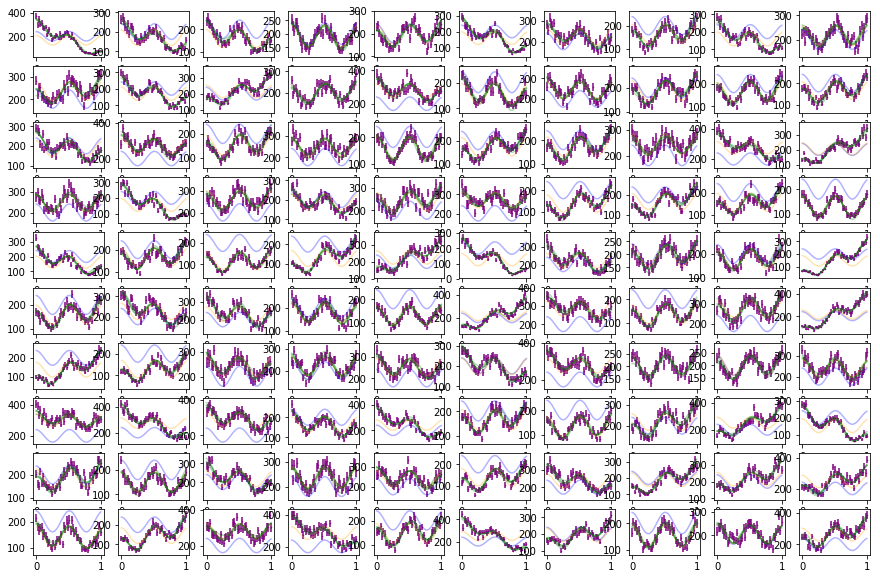

In [8]:
#Closes all insances of matplotlib
plt.close('all')
#An array to hold the calculated parameters for each run
calculated_params = []
log_evidence = []
#The array will be composed of 5 arrays, one for each parameter
for i in range(n_params):
    calculated_params.append([])

#Creates the output folder needed for multinest to run
if not os.path.exists(foldername + '_mn'):
    os.mkdir(foldername + '_mn')

#Initialized counting variable, for ploting purpuses
k = 0

for y_data, y_error in y_data_set:
    
    #Current coordinates of the plot
    i = k % n_i_plots
    j = int(k / (n_j_plots))
    
    #Running MultiNest. 100 live points chosen for the sake of presentation. real simulations are run with 400+ live points
    pymultinest.run(loglike, prior, n_params, outputfiles_basename = foldername + '_mn/mn_output_', resume = False, verbose = False, n_live_points = 100)
    json.dump(parameters, open(foldername + '_mn/jsondump.json', 'w'))

    #Analysis of the multinest output.
    analysis = pymultinest.Analyzer(outputfiles_basename=foldername + "_mn/mn_output_", n_params = n_params)
    
    #Plotting green lines for the guesses of Multinest over time.
    for (A, B, C, D, E) in analysis.get_equal_weighted_posterior()[::200,:-1]: #skip value
        plots[i, j].plot(x_data, model([A, B, C, D, E])(x_data), '-', color='green', alpha=.3, label='data')

    #Saving values obtained for the parameters
    for l in range(n_params):
        calculated_params[l].append(analysis.get_mode_stats()['modes'][0]['maximum'][l])
    
    #Saving values obtained for the log-evidence
    log_evidence.append(analysis.get_mode_stats()['global evidence'])
    
    #Increpent to counting variable
    k = k + 1

#Saving the arrays as numpy arrays
calculated_params = numpy.array(calculated_params)
log_evidence = numpy.array(log_evidence)

fig

### Statistics

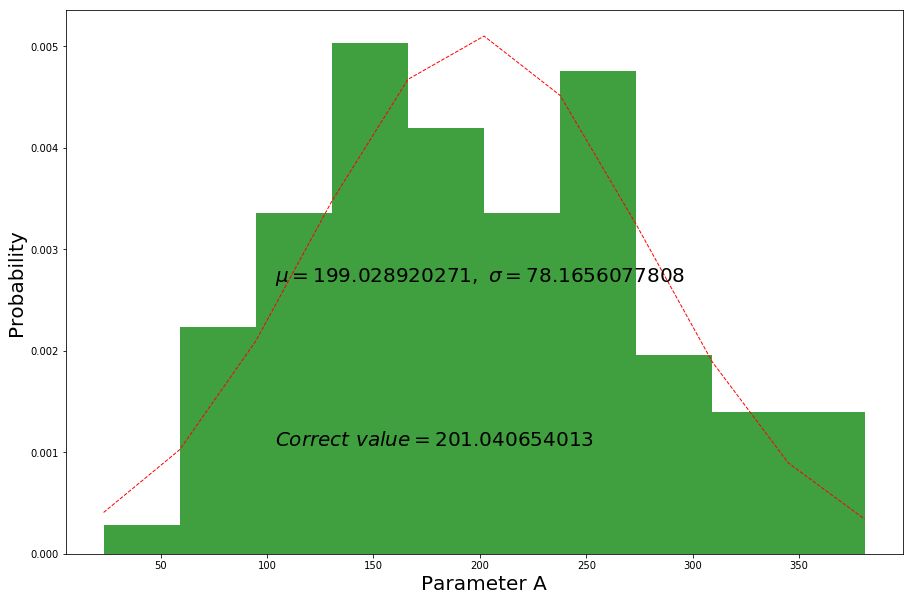

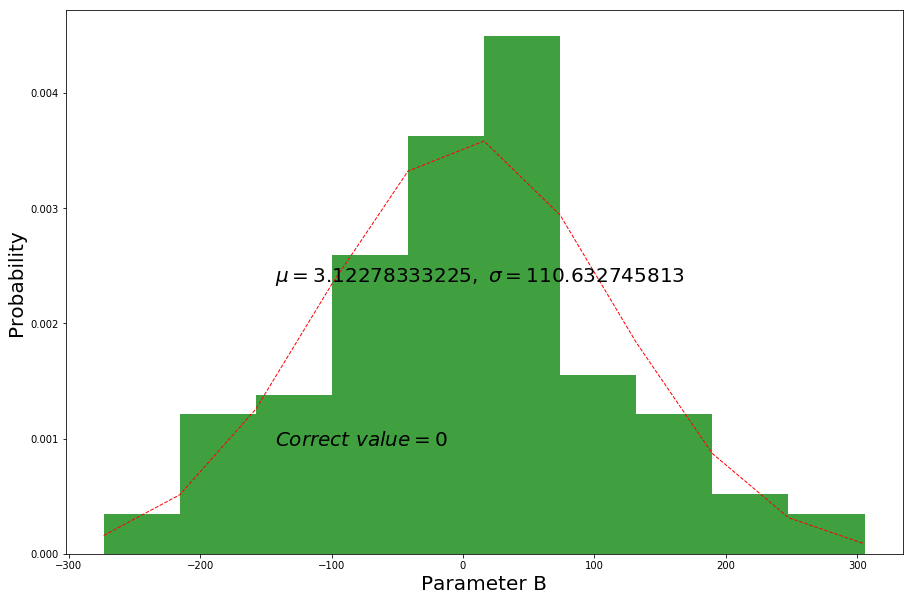

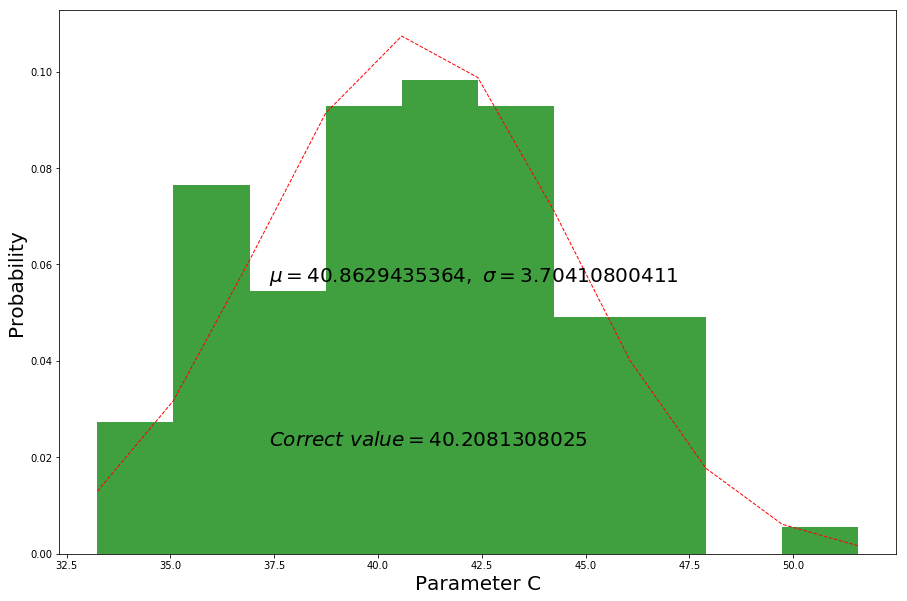

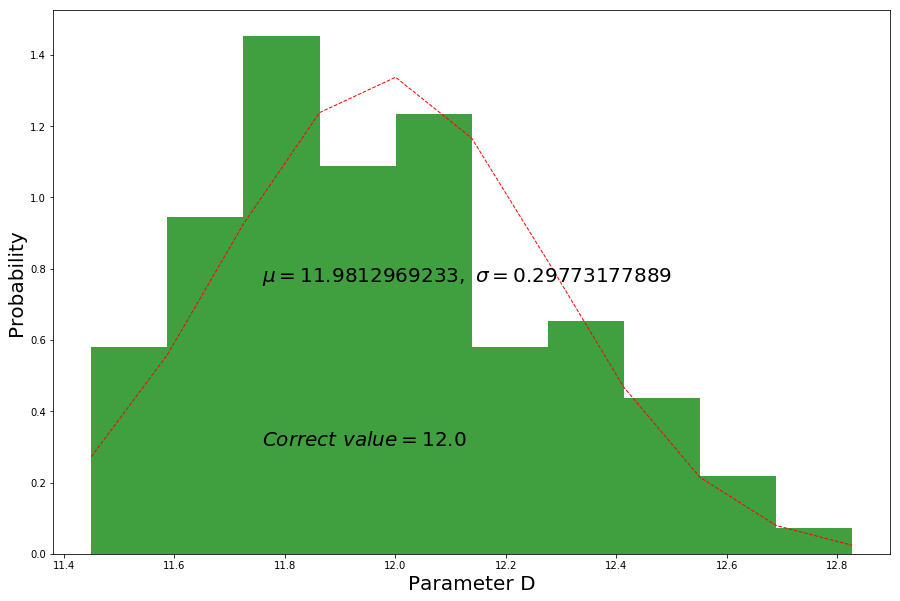

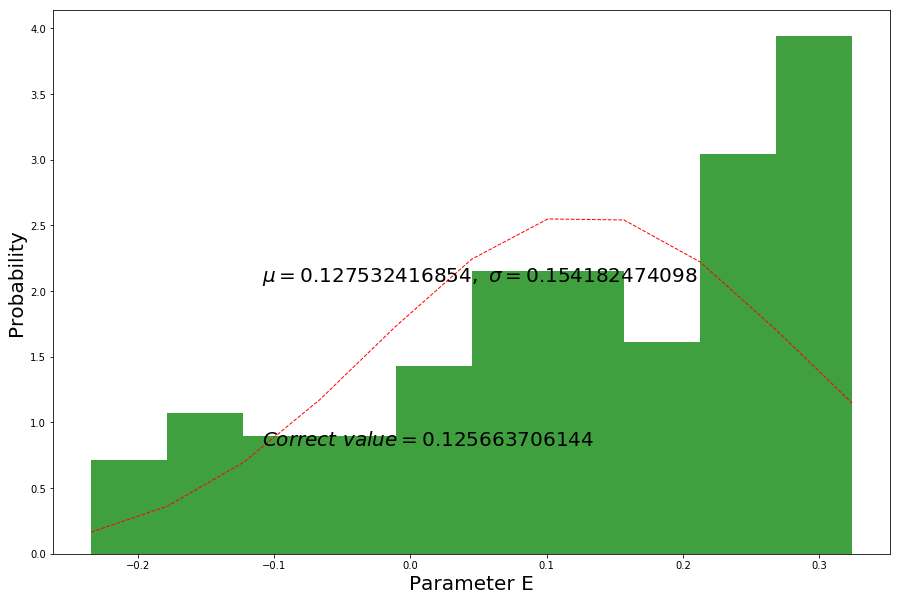

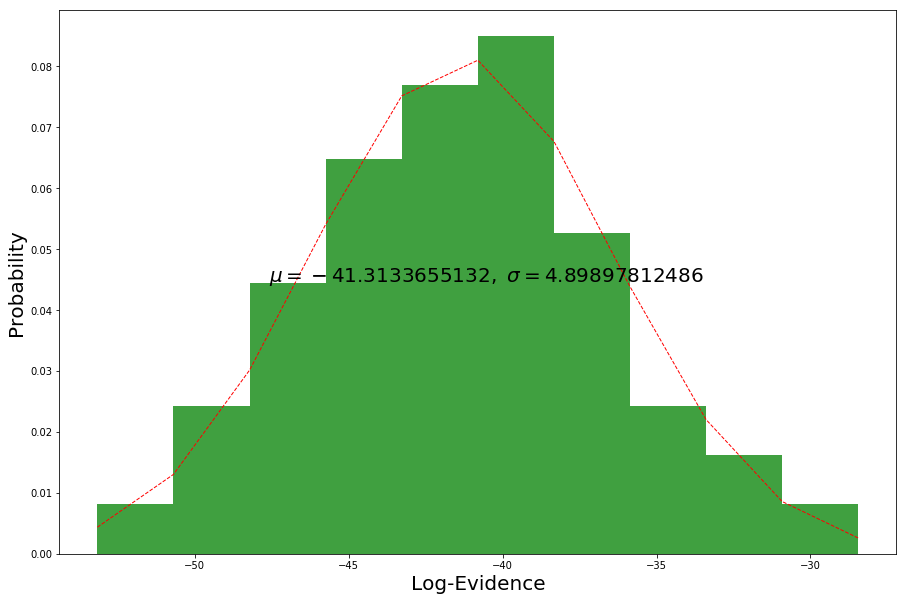

Parameter A:
Mean: 199.028920271
Sigma: 78.1656077808
Most Frequent bin: 130.490973493
Correct Values: 201.040654013


Parameter B:
Mean: 3.12278333225
Sigma: 110.632745813
Most Frequent bin: 16.0422937454
Correct Values: 0


Parameter C:
Mean: 40.8629435364
Sigma: 3.70410800411
Most Frequent bin: 40.5718248497
Correct Values: 40.2081308025


Parameter D:
Mean: 11.9812969233
Sigma: 0.29773177889
Most Frequent bin: 11.7251229991
Correct Values: 12.0


Parameter E:
Mean: 0.127532416854
Sigma: 0.154182474098
Most Frequent bin: 0.268378286576
Correct Values: 0.125663706144


Log-evidence:
Mean: -41.3133655132
Sigma: 4.89897812486
Most Frequent bin: -40.8055754197


In [9]:
#Closes last session of matplotlib
plt.close('all')

#Defines the figure size
fig_size = [15,10]
#Implements figure size on the next matplotlib session
plt.rcParams["figure.figsize"] = fig_size

bin_max = []

k = 0
for param in calculated_params:
    #Creates histogram, saving n, bins and patches in the process. Rule of thumb, n_bins = sqrt(n_points) is a good number
    n, bins, patches = plt.hist(param, int(sqrt(len(param))), normed=1, facecolor='green', alpha=0.75)
    #To plot line of best fit round it
    y = mlab.normpdf(bins, param.mean(), param.std())
    plt.plot(bins, y, 'r--', linewidth=1)
    #saves bin value that holds the greatest y-value
    bin_max.append(bins[numpy.where(n == n.max())][0])
    #Axis label
    plt.xlabel("Parameter " + parameters[k], fontsize = 20)
    plt.ylabel('Probability', fontsize = 20)
    #plot ranges
    x_min, x_max = plt.gca().get_xlim()
    y_min, y_max = plt.gca().get_ylim()
    #Writes the mean, stdev and correct value for the parameter in the plot
    plt.text(.25*(x_max-x_min)+x_min, 0.5*y_max, r'$\mu='+str(param.mean())+',\ \sigma='+str(param.std())+'$', fontsize = 20)
    plt.text(.25*(x_max-x_min)+x_min, 0.2*y_max, r'$Correct\ value='+str(correct_parameters()[k])+'$', fontsize = 20)
    #Saved plot
    
    plt.show()
    k = k + 1

n, bins, patches = plt.hist(log_evidence, int(sqrt(len(log_evidence))), normed=1, facecolor='green', alpha=0.75)
#To plot line of best fit round it
y = mlab.normpdf(bins, log_evidence.mean(), log_evidence.std())
plt.plot(bins, y, 'r--', linewidth=1)
#saves bin value that holds the greatest y-value
bin_max.append(bins[numpy.where(n == n.max())][0])
#Axis label
plt.xlabel("Log-Evidence", fontsize = 20)
plt.ylabel('Probability', fontsize = 20)
#plot ranges
x_min, x_max = plt.gca().get_xlim()
y_min, y_max = plt.gca().get_ylim()
#Writes the mean, stdev and correct value for the parameter in the plot
plt.text(.25*(x_max-x_min)+x_min, 0.5*y_max, r'$\mu='+str(log_evidence.mean())+',\ \sigma='+str(log_evidence.std())+'$', fontsize = 20)
#Saved plot
    
plt.show()

for i in range(n_params):
    print "Parameter " + parameters[i] + ":"
    print "Mean: " + str(calculated_params[i].mean())
    print "Sigma: " + str(calculated_params[i].std())
    print "Most Frequent bin: " + str(bin_max[i])
    print "Correct Values: " + str(correct_parameters()[i])
    print "\n"
print "Log-evidence:"
print "Mean: " + str(log_evidence.mean())
print "Sigma: " + str(log_evidence.std())
print "Most Frequent bin: " + str(bin_max[5])


## 1600 repetitions & 100,000 points:

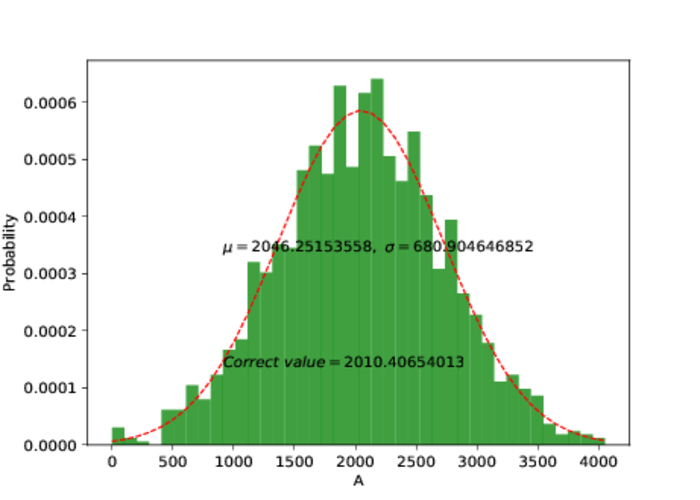

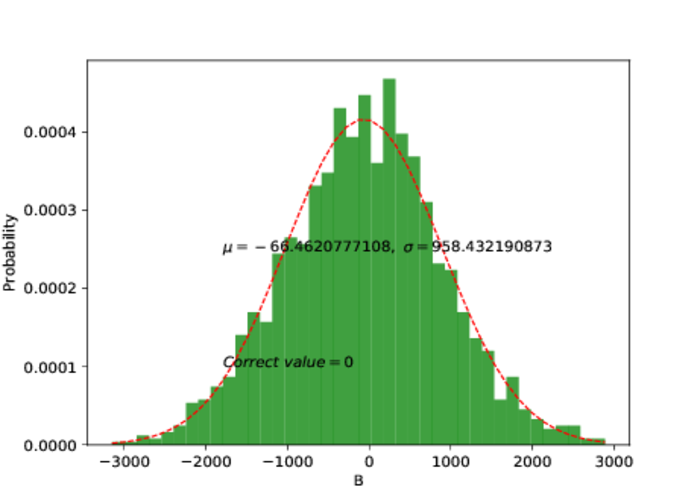

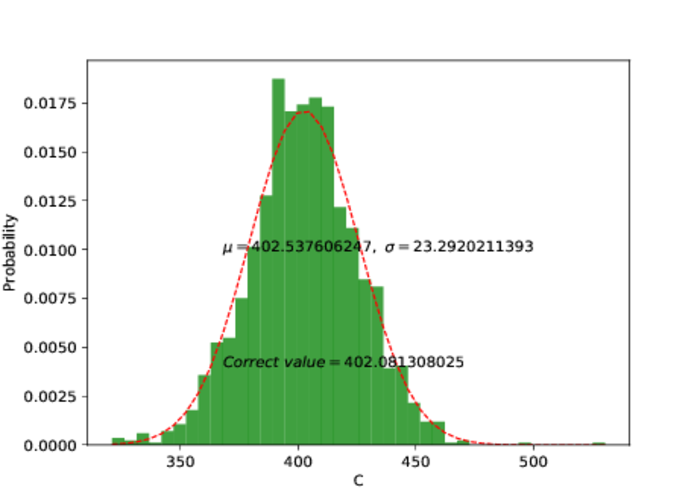

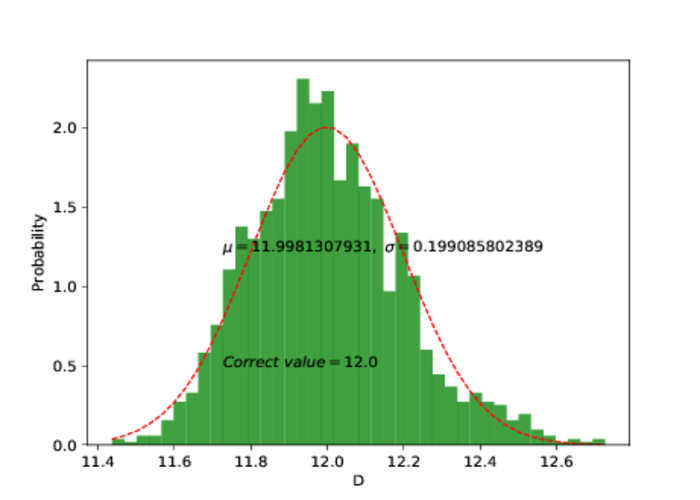

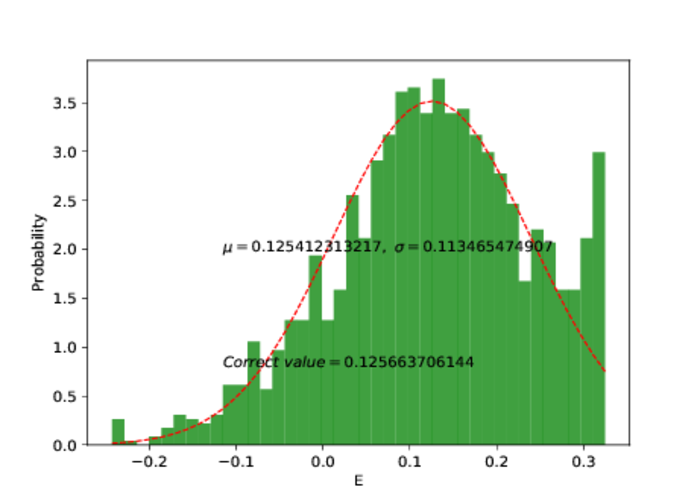

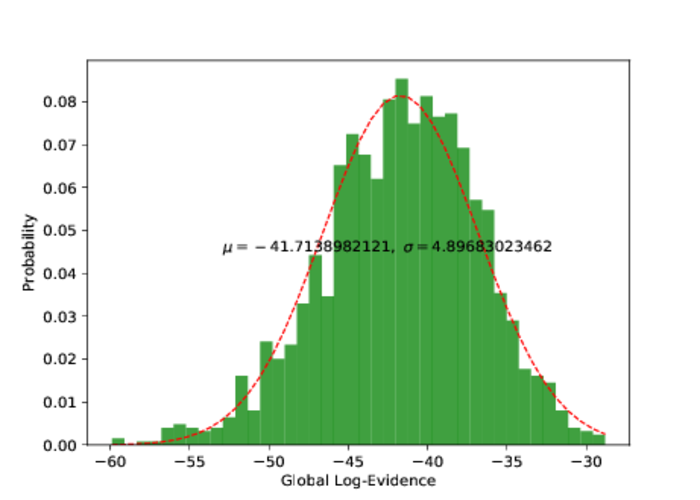

In [10]:
imgs = []
for i in range(n_params):
    img = WImage(filename='1600_reps_100000_pts/Parameter_' + parameters[i] + '_Histogram.pdf')
    img.resize(700,500)
    display(img)
    
img = WImage(filename='1600_reps_100000_pts/Global_Log_Evidence_Histogram.pdf')
img.resize(700,500)
display(img)
    
